In [1]:
import os
os.chdir('../src')

from molecular_cloud_initialization import *
from plotters import *
from cluster_cloud_initialization import *


import numpy as np
import matplotlib.pyplot as plt
from amuse.community.fi.interface import Fi
from amuse.lab import Particles, nbody_system
from amuse.couple import bridge
from amuse.units import units
from amuse.community.bhtree.interface import Bhtree
from amuse.community.seba.interface import SeBa
from amuse.ext.sink import new_sink_particles

In [2]:
tot_cloud_mass = 4/3 *units.constants.pi * (15 | units.pc)**3 * ( 2.3 | units.amu * 10 / (units.cm**3))
print(tot_cloud_mass.value_in(units.MSun))

#Assmuing a pure molecular hydrogen cloud, with typical density around 85 molecules per cm^-3, calculate the approximate cloud mass based on
#cloud size. 50 pc is selected for a small GC of only 100 stars. 

7975.78734729


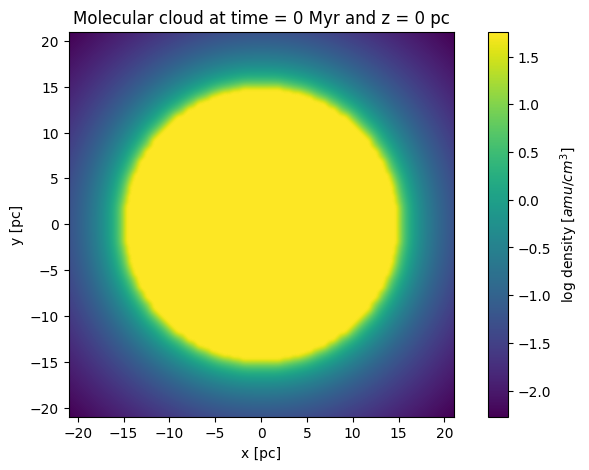

ready for evolution
Time 0.2 Myr
Time 0.4 Myr
Time 0.6 Myr
Time 0.8 Myr
Time 1.0 Myr
Time 1.2 Myr
Time 1.4 Myr
Time 1.6 Myr
Time 1.8 Myr
Time 2.0 Myr


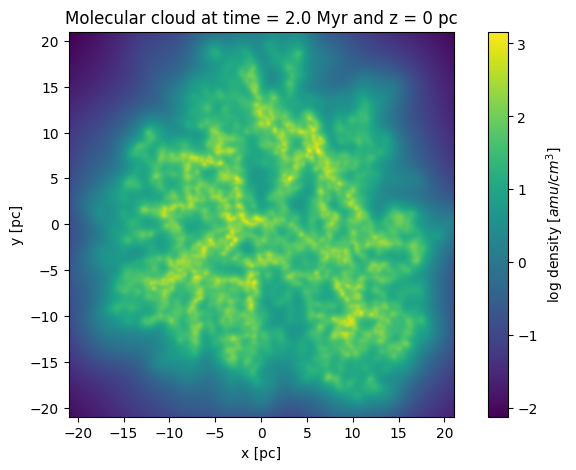

Average mass of a SPH particle 0.04911338069500312.
Mean density of the moelcular cloud 2.54832260286e-19 m**-3 * kg


In [3]:
# initialise and evolve the MC particle set
particles_cloud, converter_cloud  = make_molecular_cloud(N_cloud = 400_000,
                                                         M_cloud = 20_000 | units.MSun,
                                                         R_cloud = 15 | units.pc,
                                                         seed = 1312)

initial_particles_cloud, density_map = evolve_molecular_cloud(particles_cloud, 
                                                    converter_cloud, 
                                                    t_end = 2 | units.Myr, 
                                                    dt = 0.2 | units.Myr, 
                                                    seed = 1312)

print("Mean density of the moelcular cloud", np.mean(initial_particles_cloud.density))

In [223]:
particles_cloud = initial_particles_cloud.copy()

cluster generated


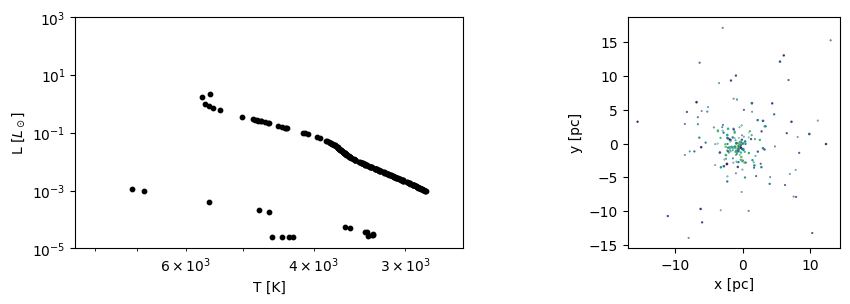

In [224]:
star_cluster = make_globular_cluster(star_count = 200,
                                    imf = "kroupa", 
                                    radius = 4 | units.pc,
                                    metallicity = 0.002, 
                                    age = 10 | units.Gyr, 
                                    seed = 2804)

star_cluster.name = "Unchanged star"

star_cluster.position +=  (-1.0, 0, 0) * (30 | units.pc)
star_cluster.velocity += (1.0, 0, 0) * (40| units.kms)

converter_cluster = nbody_system.nbody_to_si(star_cluster.mass.sum(), 
                                   star_cluster.position.sum())

In [225]:
def hydro_code(Code, dt, converter, particles, seed):
    '''
    This function contains the parameters we want to initialise the 
    hydro code with. (hard Coded)
    '''
    
    np.random.seed(seed)

    hydro = Code(converter)
    hydro.parameters.use_hydro_flag = True # Hydrodynamics flag. True means:
                            # SPH hydro included, False means: gravity only.
    hydro.parameters.gamma = 1 # gas polytropic index (1.6666667)
                        # (default value:1.6666667). In this case-> Ideal Gas   
    hydro.parameters.timestep = dt
    hydro.parameters.eps_is_h_flag = True # Default value
    hydro.parameters.radiation_flag = False # turns off radiatiative cooling/heat.
    hydro.parameters.isothermal_flag = True  # Isothermal flag. True means:
                                            # isothermal gas (requires integrate_entropy_flag == False)
    hydro.parameters.integrate_entropy_flag = False #True means: integrate
                                                     # entropy, else: internal energy. 
    hydro.gas_particles.add_particles(particles) # add the particles
   
    return hydro    

In [226]:
#initiate the gravity code with sink particles
gravity_code = Bhtree(converter_cluster)
sinks = new_sink_particles(star_cluster)

gravity_code.particles.add_particles(sinks)

stellar_evolution_code = SeBa()
stellar_evolution_code.particles.add_particles(sinks)
stellar_evolution_code.parameters.metallicity = sinks[0].metallicity


In [227]:
# #start the hydro code for the gas
hydro_cloud = hydro_code(Code = Fi, dt = 0.1 | units.Myr,
                         converter = converter_cloud,
                         particles = particles_cloud,
                         seed = 1312)


channel = {"gravity_to_sinks": gravity_code.particles.new_channel_to(sinks),
            "gravity_from_sinks": sinks.new_channel_to(gravity_code.particles),
            "stellar_evolution_to_sinks": stellar_evolution_code.particles.new_channel_to(sinks),
            "stellar_evolution_from_sinks": sinks.new_channel_to(stellar_evolution_code.particles),
            "to_cloud": hydro_cloud.gas_particles.new_channel_to(particles_cloud),
            "from_cloud": particles_cloud.new_channel_to(hydro_cloud.gas_particles)}

In [228]:
gravhydrostellarbridge = bridge.Bridge(use_threading = False)
gravhydrostellarbridge.add_system(gravity_code, (hydro_cloud, stellar_evolution_code))
gravhydrostellarbridge.add_system(hydro_cloud, (gravity_code, stellar_evolution_code))
gravhydrostellarbridge.add_system(stellar_evolution_code, (gravity_code, hydro_cloud))
gravhydrostellarbridge.timestep = 0.1 | units.Myr

In [229]:
def bondi_radius(stellar_mass):
    sound_speed = 0.2 | units.kms
    R = 2 * units.constants.G * stellar_mass /(sound_speed **2)
    
    return R

# def bondi_accretion_rate(rho,v,r):
#     dM = units.constants.pi * (r**2) * rho * v

#     return dM

In [230]:
def detect_bounded_gas(star,particles,hardness):

    n = len(particles)

    if n == 0:
        return Particles()
    
    total_Ek=(0.5*particles.mass*(particles.vx**2+particles.vy**2+particles.vz**2)).sum()
    average_Ek=total_Ek/particles.mass.sum()
    max_mass=particles.mass.amax()
    limitE=hardness*average_Ek

    a=np.argsort(particles.x.number)
    binaries = Particles()

    for i in range(n):
        r2=(star.x-particles.x[a[i]])**2+ \
            (star.y-particles.y[a[i]])**2+ \
            (star.z-particles.z[a[i]])**2 
        v2=(star.vx-particles.vx[a[i]])**2+ \
            (star.vy-particles.vy[a[i]])**2+ \
            (star.vz-particles.vz[a[i]])**2 
        r=r2**0.5
        #Specific binding energy in units energy per mass
        eb=abs(units.constants.G*(particles.mass[a[i]]+star.mass)/r-0.5*v2)
        if eb > limitE:
            binary=particles[[a[i]]].copy()
            binary.hardness=eb/average_Ek
            binaries.add_particle(binary)
    
    return binaries

In [231]:
def free_fall_time(star, particles, time_step):

    n = len(particles)
    
    if n == len(particles):
        return Particles()
    
    a = np.argsort(particles.x.number)
    binaries = Particles()
    
    for i in range(n):
        
        distance = np.sqrt((star.x-particles.x[a[i]])**2 + \
                            (star.y-particles.y[a[i]])**2 + \
                            (star.z-particles.z[a[i]])**2)
        
        tff = 0.5*np.pi*distance**(3/2)/np.sqrt(2*units.constants.G*(star.mass + particles.mass[a[i]]))

        if tff < time_step:
            binary = particles[[a[i]]].copy()
            binaries.add_particle(binary)

    return binaries

In [232]:
def accrete_mass(sinks, hydro_particles, time_step):
    # For each sink, find the hydro particles that are located within the sink radius
    particles_within_sink_radius = sinks.select_too_close(hydro_particles)

    for idx in range(len(sinks)):
        # Select the ones that are gravitationally bound to the sink
        bounded_particles = detect_bounded_gas(sinks[idx], particles_within_sink_radius[idx], hardness = 0.1)
        # bounded_particles = free_fall_time(sinks[idx], bounded_particles, time_step)
        if len(bounded_particles) != 0:
            # Update the mass of the sink
            sinks[idx].name = "Accreted star"
            sinks[idx].mass += bounded_particles.mass.sum()
            # Remove the accreted particles from the particle cloud
            hydro_particles.remove_particles(bounded_particles)

In [233]:
# sinks.sink_radius = [bondi_radius(sink.mass).in_(units.pc) for sink in sinks]
# accrete_mass(sinks, particles_cloud, 0.1 | units.Myr)

In [234]:
def plot_cloud_and_star_cluster(time, hydro, sinks, x_lim, y_lim, N, density_map_MC):
    
    rho = make_map(hydro, x_lim = x_lim, y_lim = y_lim, N = N)

    colors = np.array(["black", "aliceblue"])
    colors_sink = np.array([0 if sink.name == "Unchanged star" else 1 for sink in sinks])

    fig = plt.figure(figsize = (9, 5))

    plt.imshow(np.log10(rho.value_in(units.amu/units.cm**3)), cmap = "plasma", extent = [-x_lim, x_lim, -y_lim, y_lim])
    plt.scatter(sinks.position.x.value_in(units.pc), sinks.position.y.value_in(units.pc), c = colors[colors_sink], s = sinks.mass.value_in(units.MSun)*5)

    plt.title(f"Molecular cloud at time = {time.value_in(units.Myr)} Myr")
    plt.xlabel("x [pc]")
    plt.ylabel("y [pc]")
    plt.xlim([-x_lim, x_lim])
    plt.ylim([-y_lim, y_lim])

    colorbar_axis = fig.add_axes([0.95, 0.1, 0.02, 0.85])
    colorbar = plt.colorbar(density_map_MC, cax = colorbar_axis, fraction = 0.046, pad = 0.04)
    colorbar.set_label('log density [$amu/cm^3$]', labelpad = 5)

    plt.show()

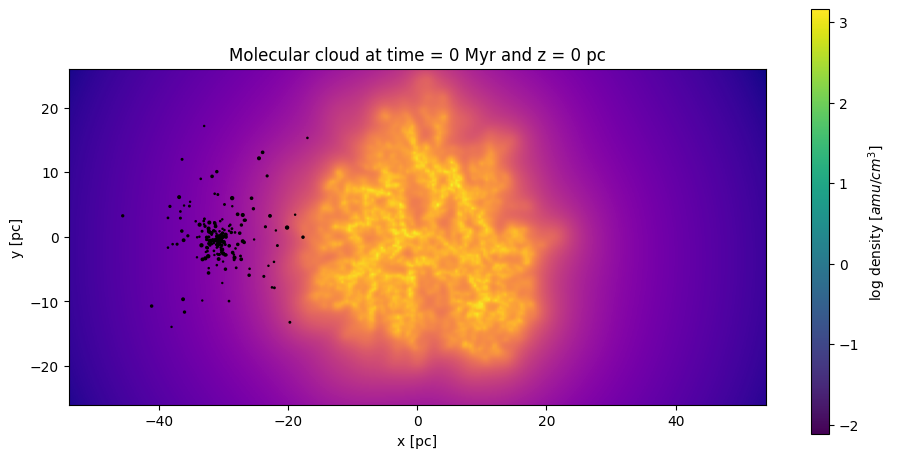

Largest sink radius 0.219611656536 parsec
Pre accretion cluster mass 68.9282687749 MSun
Sinks in progress at 0.1  Myr.
Post accretion cluster mass 68.9282687749 MSun
407221 number of cloud particles now


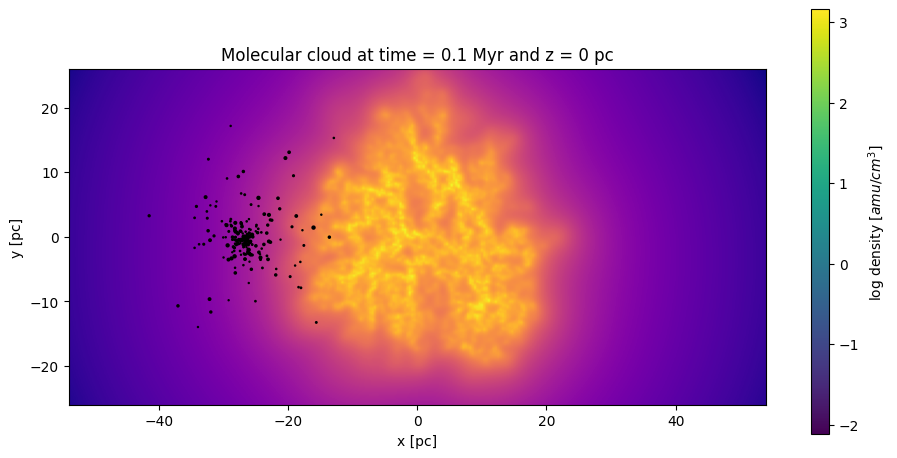

Largest sink radius 0.219611656536 parsec
Pre accretion cluster mass 68.9282687749 MSun
Sinks in progress at 0.2  Myr.
Post accretion cluster mass 68.9773821556 MSun
407220 number of cloud particles now


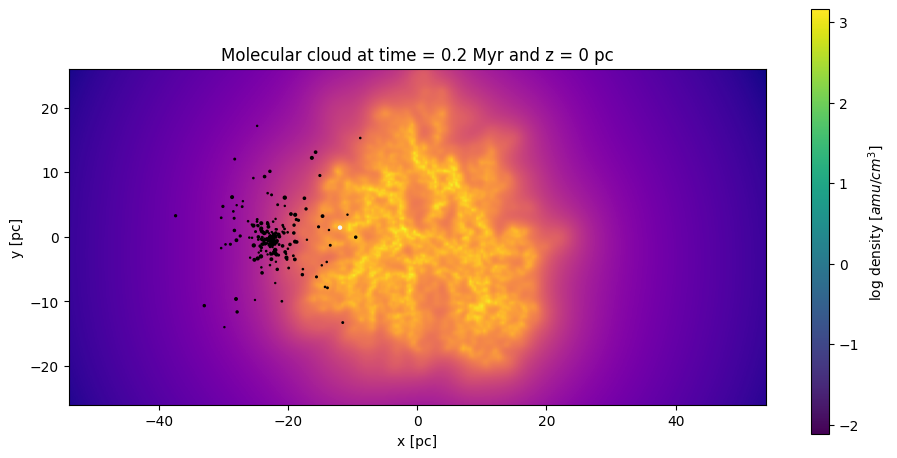

Largest sink radius 0.219611656536 parsec
Pre accretion cluster mass 68.9773821556 MSun
Sinks in progress at 0.3  Myr.
Post accretion cluster mass 69.0264955363 MSun
407219 number of cloud particles now


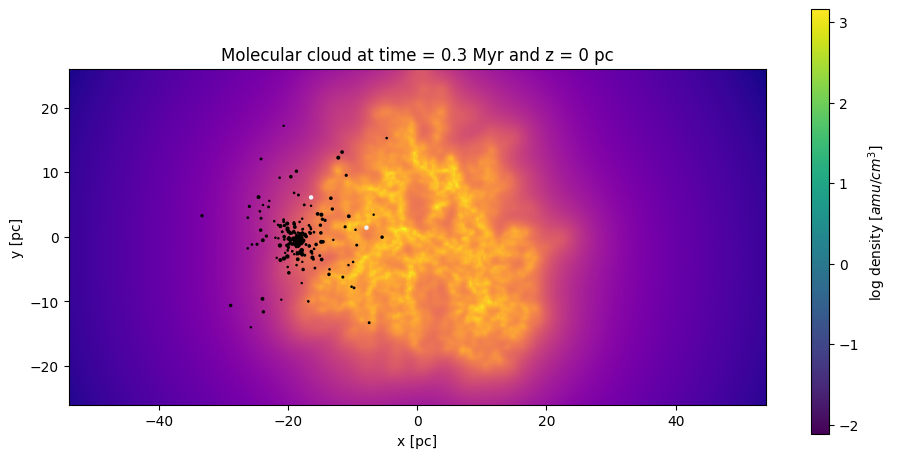

Largest sink radius 0.219611656536 parsec
Pre accretion cluster mass 69.0264955363 MSun
Sinks in progress at 0.4  Myr.
Post accretion cluster mass 69.3211758204 MSun
407213 number of cloud particles now


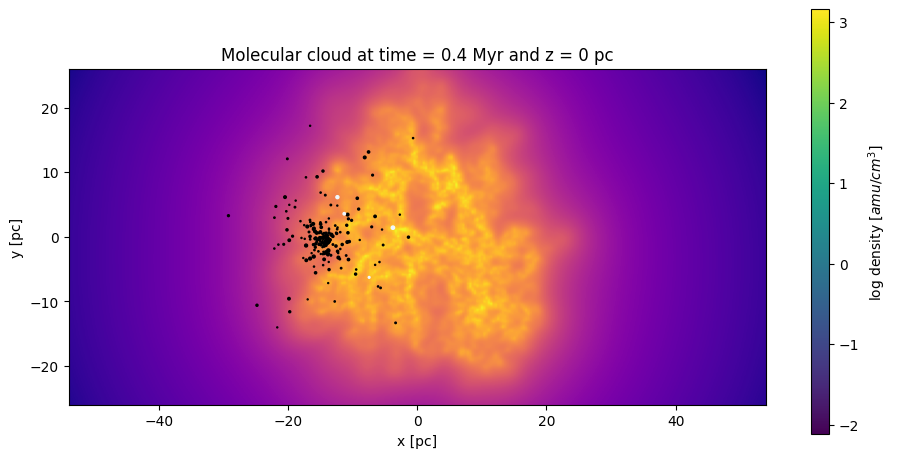

Largest sink radius 0.250740547314 parsec
Pre accretion cluster mass 69.3211758204 MSun
Sinks in progress at 0.5  Myr.
Post accretion cluster mass 70.2052166729 MSun
407195 number of cloud particles now


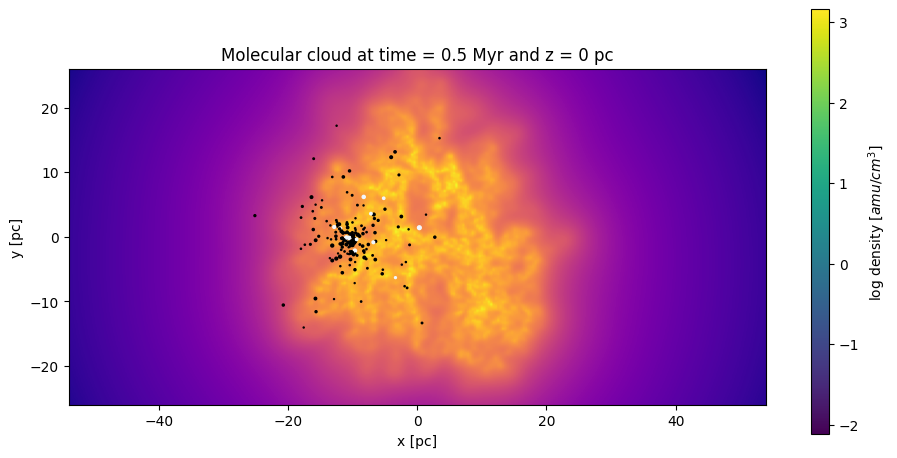

Largest sink radius 0.314126391147 parsec
Pre accretion cluster mass 70.2052166729 MSun
Sinks in progress at 0.6  Myr.
Post accretion cluster mass 71.8750716166 MSun
407161 number of cloud particles now


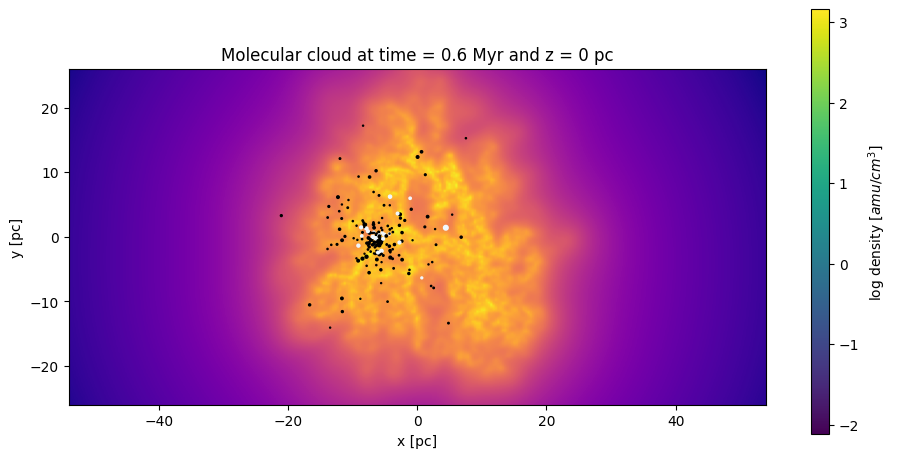

Largest sink radius 0.483155308037 parsec
Pre accretion cluster mass 71.8750716166 MSun
Sinks in progress at 0.7  Myr.
Post accretion cluster mass 74.1834005092 MSun
407114 number of cloud particles now


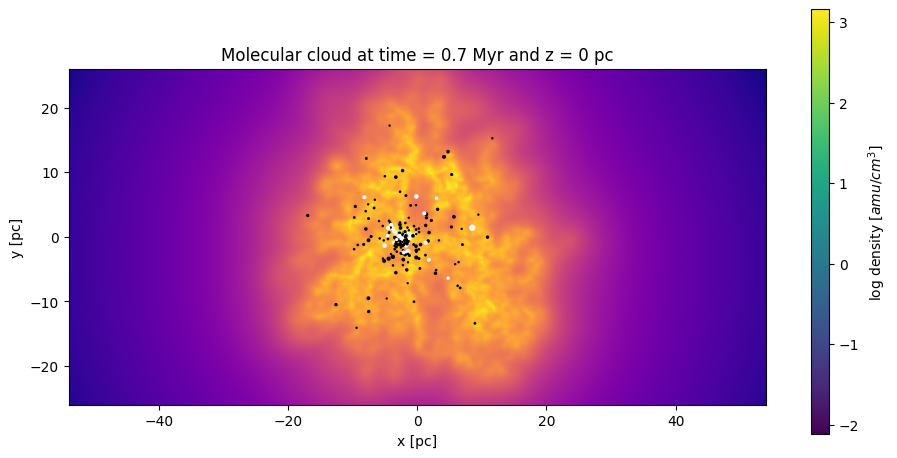

Largest sink radius 0.567669766482 parsec
Pre accretion cluster mass 74.1834005092 MSun
Sinks in progress at 0.8  Myr.
Post accretion cluster mass 76.6881829247 MSun
407063 number of cloud particles now


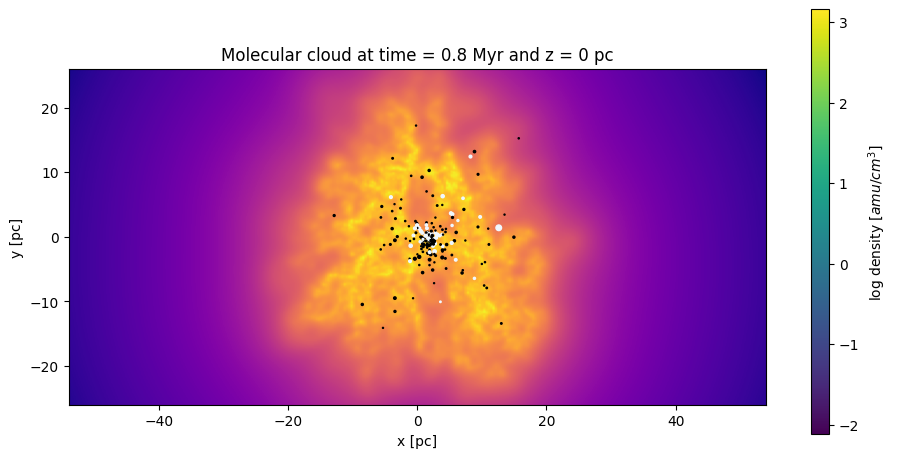

Largest sink radius 0.705005761455 parsec
Pre accretion cluster mass 76.6881829247 MSun
Sinks in progress at 0.9  Myr.
Post accretion cluster mass 78.7018315332 MSun
407022 number of cloud particles now


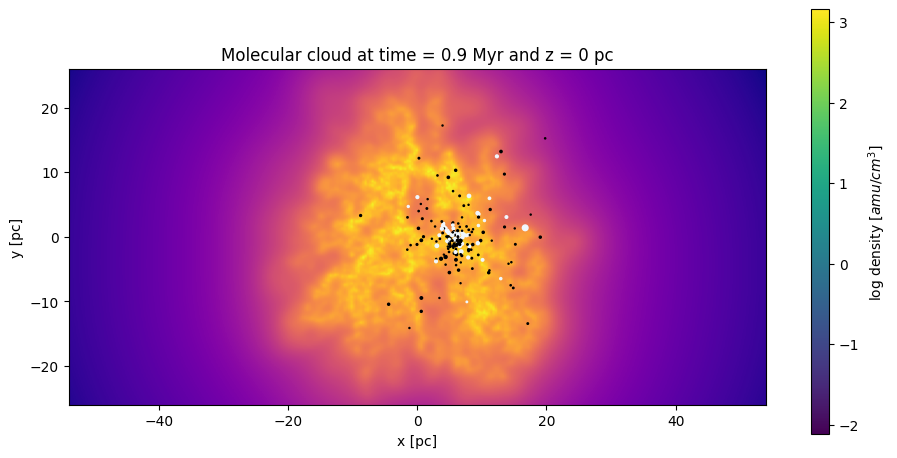

Largest sink radius 0.715570068761 parsec
Pre accretion cluster mass 78.7018315332 MSun
Sinks in progress at 1.0  Myr.
Post accretion cluster mass 80.3225730961 MSun
406989 number of cloud particles now


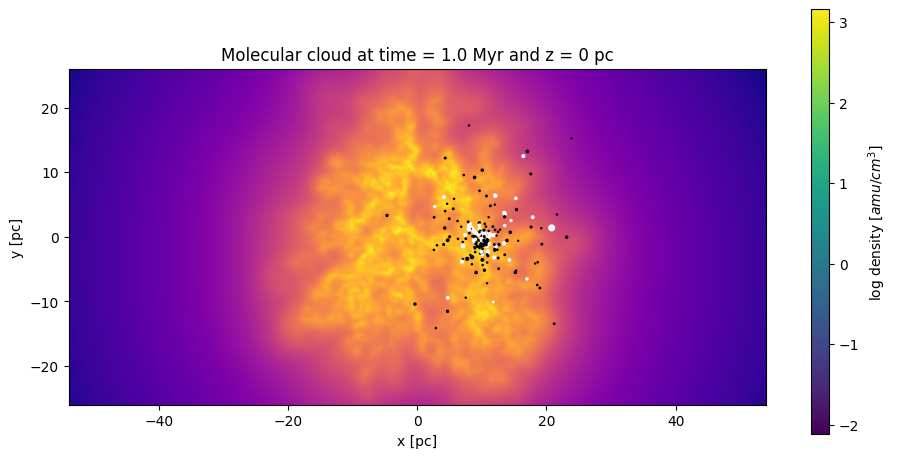

Largest sink radius 0.715570068761 parsec
Pre accretion cluster mass 80.3225730961 MSun
Sinks in progress at 1.1  Myr.
Post accretion cluster mass 81.0592738065 MSun
406974 number of cloud particles now


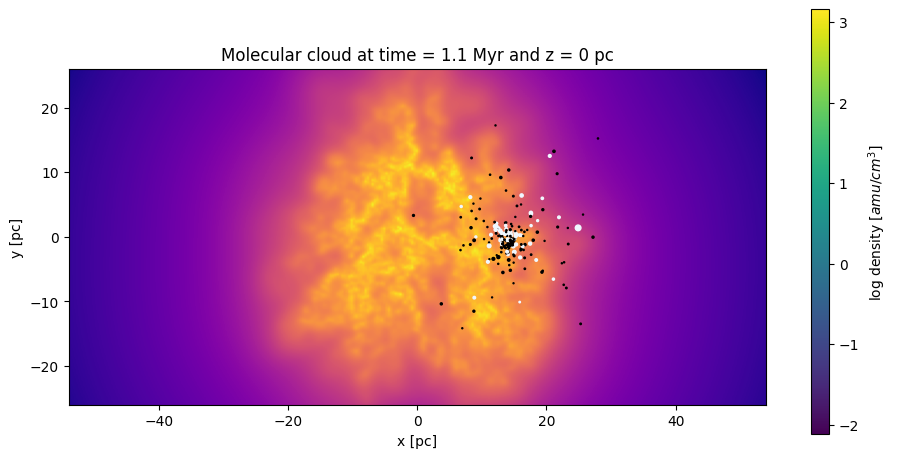

Largest sink radius 0.715570068761 parsec
Pre accretion cluster mass 81.0592738065 MSun
Sinks in progress at 1.2  Myr.
Post accretion cluster mass 81.4521808521 MSun
406966 number of cloud particles now


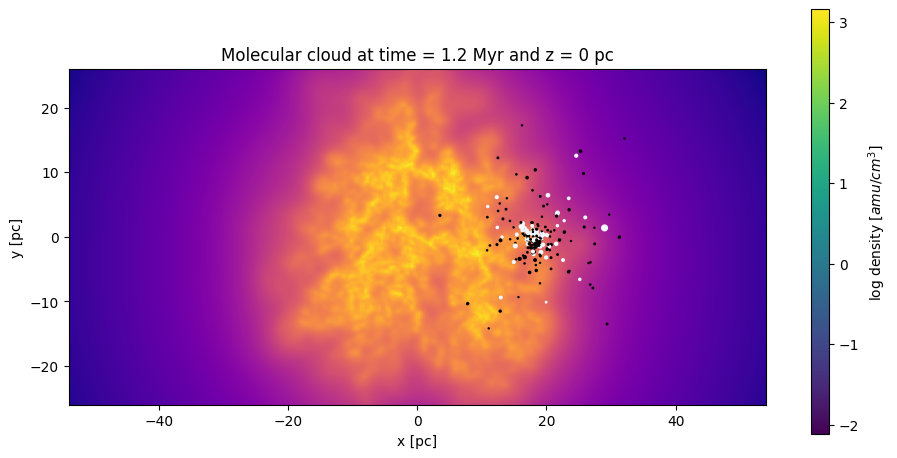

Largest sink radius 0.715570068761 parsec
Pre accretion cluster mass 81.4521808521 MSun
Sinks in progress at 1.3  Myr.
Post accretion cluster mass 81.5012942328 MSun
406965 number of cloud particles now


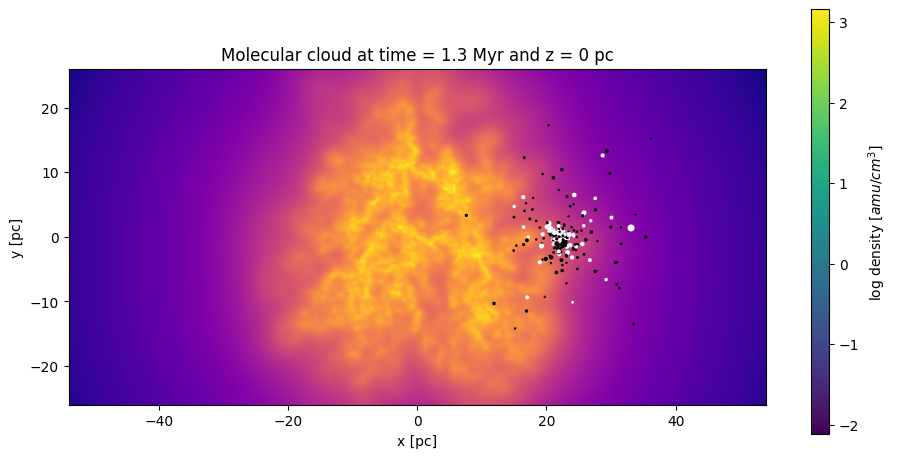

Largest sink radius 0.715570068761 parsec
Pre accretion cluster mass 81.5012942328 MSun
Sinks in progress at 1.4  Myr.
Post accretion cluster mass 81.5012942328 MSun
406965 number of cloud particles now


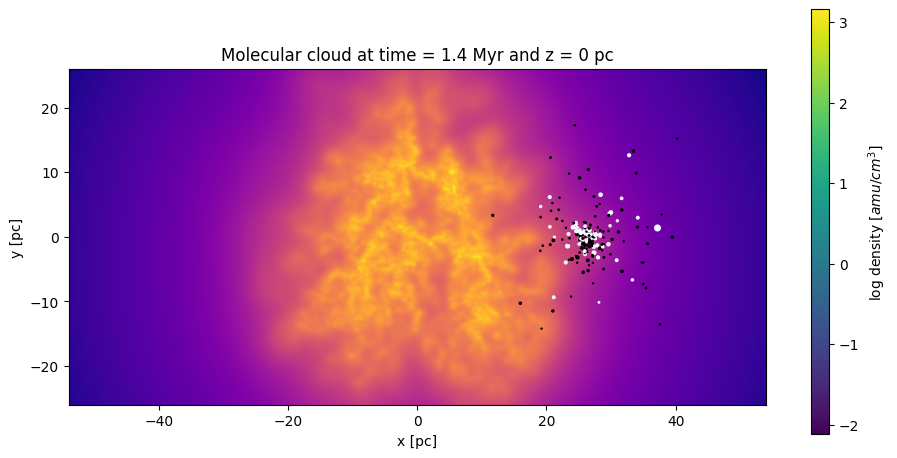

Largest sink radius 0.715570068761 parsec
Pre accretion cluster mass 81.5012942328 MSun
Sinks in progress at 1.5  Myr.
Post accretion cluster mass 81.5012942328 MSun
406965 number of cloud particles now


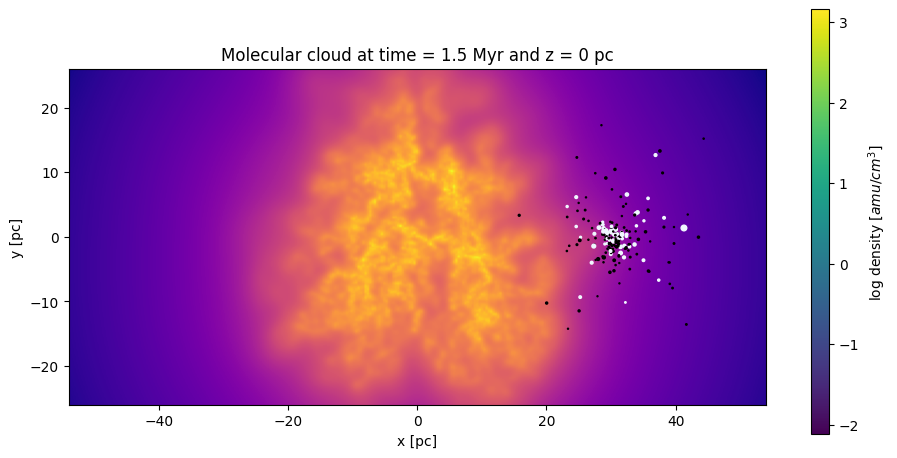

In [235]:
t_end = 1.5 | units.Myr
model_time = 0 | units.Myr
dt = 0.1 | units.Myr

x_lim = int(abs(min(sinks.position.x).value_in(units.pc)))*1.2
y_lim = int(abs(min(sinks.position.y).value_in(units.pc)))*2
N = 300

plot_cloud_and_star_cluster(model_time, hydro_cloud, sinks, x_lim, y_lim, N, density_map)

sinks_mass_snapshots = []

while model_time < t_end:
    
    # define the accreting radius of the sinks particle based on its Bondi radius
    # IMPORTANT: the mass changes after each accretion event
    sinks.sink_radius = [bondi_radius(sink.mass).in_(units.pc) for sink in sinks]
    
    print("Largest sink radius", max(sinks.sink_radius).in_(units.pc))

    print("Pre accretion cluster mass", sinks.mass.sum())
    
    model_time += dt
    model_time = model_time.round(1)
    # evolve the gravity and hydro codes through our bridge
    gravhydrostellarbridge.evolve_model(model_time)


    # update channels (copy over from the codes.particles to the particle sets)
    channel["gravity_to_sinks"].copy()
    channel["stellar_evolution_to_sinks"].copy()
    channel["to_cloud"].copy()

    print("Sinks in progress at", model_time.value_in(units.Myr), " Myr.")
    # add the acretted mass to the sinks's total mass
    accrete_mass(sinks, particles_cloud, dt)

    # update channels (copy the information from the particle set to the gravity code)
    channel["gravity_from_sinks"].copy()
    channel["stellar_evolution_from_sinks"].copy()
    channel["from_cloud"].copy()

    # save the total mass of each step
    sinks_mass_snapshots.append(sinks.mass.value_in(units.MSun))

    print("Post accretion cluster mass", sinks.mass.sum())
    print(len(particles_cloud.mass), "number of cloud particles now")

    plot_cloud_and_star_cluster(model_time, hydro_cloud, sinks, x_lim, y_lim, N, density_map)


In [236]:
mass_difference = sinks_mass_snapshots[-1] - sinks_mass_snapshots[0]
mass_difference

array([  9.82267614e-02,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   3.43793665e-01,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   9.82267614e-02,
         5.55111512e-17,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   2.94680284e-01,
         0.00000000e+00,   9.82267614e-02,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   5.55111512e-17,
         4.91133807e-02,   3.43793665e-01,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   2.45566903e-01,   0.00000000e+00,
         0.00000000e+00,   4.91133807e-02,   0.00000000e+00,
         0.00000000e+00,   9.82267614e-02,   9.82267614e-02,
         0.00000000e+00,   4.91133807e-02,   0.00000000e+00,
         1.96453523e-01,   0.00000000e+00,   5.55111512e-17,
         2.45566903e-01,   0.00000000e+00,   3.43793665e-01,
         1.38777878e-17,

In [237]:
mask = np.where(mass_difference > 1e-15)

In [238]:
len(mask[0])

60

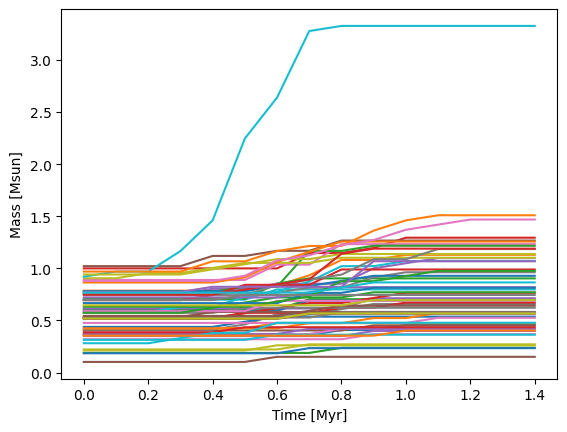

In [239]:
plt.plot(np.arange(0, 1.5, 0.1), np.array(sinks_mass_snapshots)[:, mask[0]])
plt.xlabel("Time [Myr]")
plt.ylabel("Mass [Msun]")
plt.show()
# add vertical lines for when the cluster enters and leaves the cloud 

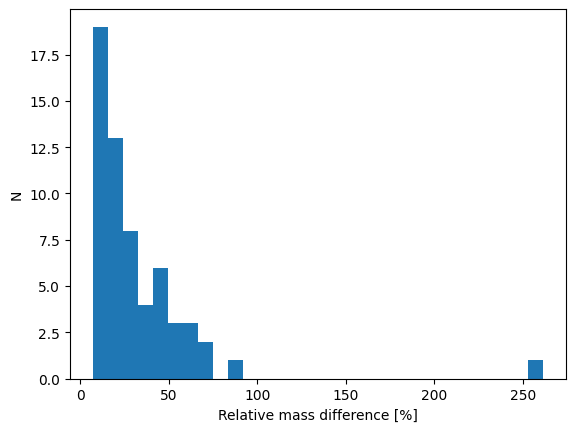

In [248]:
relative_mass = np.array(mass_difference)[mask[0]]/np.array(sinks_mass_snapshots[0])[mask[0]]
plt.hist(relative_mass*100, bins  = 30)
plt.xlabel("Relative mass difference [%]")
plt.ylabel("N")
plt.show()

In [250]:
gravity_code.stop()
hydro_cloud.stop()
stellar_evolution_code.stop()
gravhydrostellarbridge.stop()